
                      Black box attack

Definition:
Black-box attacks refer to adversarial attacks conducted on machine learning models without having direct access to their internal parameters, architecture, or training data. In a black-box setting, the attacker can only interact with the model through input-output queries, similar to an external user. The attacker aims to manipulate the model's behavior by crafting inputs that exploit its vulnerabilities and cause it to make incorrect predictions or misclassify data.

Importance:

Real-World Scenarios: Black-box attacks reflect real-world scenarios where attackers often lack complete knowledge of the target model's internals. Proprietary models, commercial APIs, or deployed systems may have limited visibility into their inner workings. Understanding black-box attacks helps evaluate the security of machine learning models in practical contexts.

Model Robustness Assessment: Black-box attacks provide insights into the vulnerability of machine learning models against real-world threats. By probing the model's behavior and finding ways to manipulate its outputs without direct access to internal details, researchers and practitioners can identify weaknesses and improve model robustness.

Adversarial Example Generation: Black-box attacks facilitate the generation of adversarial examples, which are carefully crafted inputs designed to deceive machine learning models. Adversarial examples demonstrate the model's susceptibility to small perturbations, showcasing its limitations and the need for improved defenses against adversarial attacks.

Transferability Analysis: Black-box attacks explore the transferability of adversarial examples across different instances of the same model or even across different models. Understanding transferability helps assess the generalizability of adversarial attacks and their potential impact across various target models, strengthening the awareness of vulnerabilities.

Defense Mechanism Development: Studying black-box attacks aids in the development of effective defense mechanisms to enhance model security. Analyzing attack methods, techniques, and patterns helps researchers design robust models that are more resilient against different types of adversarial attacks, ultimately improving the overall security of machine learning systems.

By investigating the limitations and capabilities of black-box attacks, researchers and practitioners can gain a deeper understanding of the security risks associated with machine learning models. This knowledge drives the development of more robust and secure AI systems, ensuring their reliability and trustworthiness in real-world applications.

#imprtant thing for attack tool box, if here has issue for using the attack tool box, just comment out !pip install adversarial-robustness-toolbox and rerun the code again.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install adversarial-robustness-toolbox

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 49.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import sys
from pathlib import Path
import datetime
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import Adam, SGD
from matplotlib import pyplot as plt
from art.attacks.evasion import BoundaryAttack
from art.estimators.classification import KerasClassifier
from art.utils import to_categorical
from art.attacks.evasion import ProjectedGradientDescent
import imageio
from tensorflow.keras.applications import vgg16

# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.12.0
Keras version:2.12.0


In [3]:
# Uncompress the dataset 
!unzip -uq "/content/drive/MyDrive/ass1/SCENES_700x700.zip" -d "sample_data/"

In [4]:
# Function to load the images and the labels from the dataset
def load_images_and_labels(directory):

    imgs_list = []
    labels_list = []

    # List of all subfolders in the directory
    subfolders_list_1 = listdir(directory)
    # Make sure that the subfolders are sorted 
    subfolders_list = natsort.natsorted(subfolders_list_1)

    # Assign a label to each folder with images (0 to the first folder)
    lab = 0
    for subfolder_name in subfolders_list:
        sub_dir_path = directory + '/' + subfolder_name

        # Read the images as numpy arrays
        imagesList = listdir(sub_dir_path)
        for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
          # Resize all images to 224 x 224 pixels
          resized_img = cv2.resize(tmp_img, (224, 224)) 
          img_arr = np.array(resized_img)
          imgs_list.append(img_arr.astype(float))
          labels_list.append(lab)
        lab += 1
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)

    return imgs, labels

# Use the above function to load the images and labels
all_images, all_labels = load_images_and_labels('sample_data/SCENES_700x700')

In [5]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=11)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images

In [6]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

# Note that the images are in the [0,255] range, to keep the data consistent with the notebook example of the attack

# In the example, the mean channel values of the images were subtracted: you don't need to apply that, unless you wish to

Images train shape: (2838, 224, 224, 3) - Labels train shape: (2838,)
Images validation shape: (710, 224, 224, 3) - Labels validation shape: (710,)
Images test shape: (888, 224, 224, 3) - Labels test shape: (888,)

Max pixel value 255.0
Min pixel value 0.0
Average pixel value 120.89950520514981
Data type float64


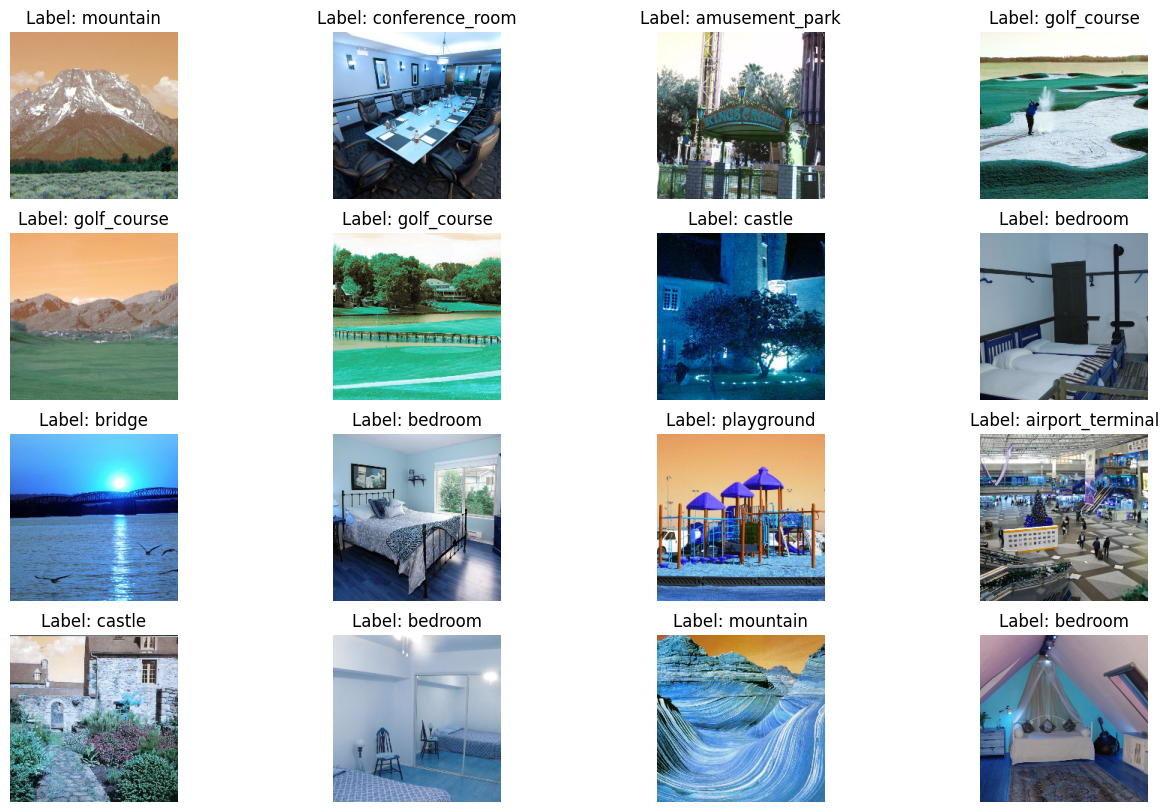

In [7]:
# A list with the names of the image classes
label_names = ['airport_terminal', 'amusement_park', 'bedroom', 'bridge', 'castle', 'conference_room',
               'golf_course', 'highway', 'mountain', 'playground']
               
# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(16):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(4, 4, n+1)
    plt.imshow(train_images[i[0]].astype(int))
    plt.title('Label: ' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

In [8]:
NUM_CLASSES = 10

train_labels_onehot = to_categorical(train_labels, NUM_CLASSES)
val_labels_onehot = to_categorical(val_labels, NUM_CLASSES)
test_labels_onehot = to_categorical(test_labels, NUM_CLASSES)
trainval_labels_onehot = to_categorical(trainval_labels, NUM_CLASSES)
# Remember:
# 1. If you use one-hot vectors for the labels, the loss function in the model needs to be 'categorical_crossentropy'
# 2. If you use a single class value for the labels, the loss in the model needs to be 'sparse_categorical_crossentropy'

In [9]:
                            # Number of labels
BATCH_SIZE = 36                             # Size of batch
HEIGHT = 224                                 # Height of input image
WIDTH = 224                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 3                             # Number of output dimension
# Set training hyperparameters
NUM_EPOCH = 10                         # Number of epoch to train
LR = 0.001                                 # Learning rate

In [10]:

# load ResNet50 model with imagenet pretrained in Keras API (NOT INCLUDE TOP DENSE LAYERS)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=keras.layers.Input((224,224,3)))
# Fine-tune ResNet50 mdodel.
# Add several Dense layers on top of it and a softmax dense layer with output dense of 3 labels
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=[base_model.input], outputs=[predictions])

Instructions for updating:
Colocations handled automatically by placer.


94765736/94765736 [==============================] - 3s 0us/step


In [11]:
#@title Default title text
# SGD optimizer
optimizer = keras.optimizers.SGD(learning_rate=LR)
# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
# reduce lr based on val_loss
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.01)
# compile the keras model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
# fit the keras model on the dataset with validation for monitoring validation loss and accuracy at the end of each epoch
history = model.fit(train_images, train_labels_onehot, epochs = NUM_EPOCH, batch_size = BATCH_SIZE, validation_data = (val_images, val_labels_onehot))

Train on 2838 samples, validate on 710 samples
Epoch 1/10
2838/2838 [==============================] - ETA: 0s - loss: 2.2984 - accuracy: 0.2262

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2838/2838 [==============================] - 33s 12ms/sample - loss: 2.2984 - accuracy: 0.2262 - val_loss: 1.6183 - val_accuracy: 0.5958
Epoch 2/10
2838/2838 [==============================] - 16s 6ms/sample - loss: 1.7304 - accuracy: 0.4200 - val_loss: 1.1730 - val_accuracy: 0.7634
Epoch 3/10
2838/2838 [==============================] - 16s 6ms/sample - loss: 1.3644 - accuracy: 0.5733 - val_loss: 0.8609 - val_accuracy: 0.8366
Epoch 4/10
2838/2838 [==============================] - 16s 6ms/sample - loss: 1.0674 - accuracy: 0.6868 - val_loss: 0.6532 - val_accuracy: 0.8662
Epoch 5/10
2838/2838 [==============================] - 16s 6ms/sample - loss: 0.8670 - accuracy: 0.7569 - val_loss: 0.5002 - val_accuracy: 0.8915
Epoch 6/10
2838/2838 [==============================] - 16s 6ms/sample - loss: 0.6989 - accuracy: 0.8076 - val_loss: 0.4117 - val_accuracy: 0.9085
Epoch 7/10
2838/2838 [==============================] - 16s 6ms/sample - loss: 0.5809 - accuracy: 0.8295 - val_loss: 0.3464 - va

In [12]:
results = model.evaluate(test_images, test_labels_onehot)
print("test loss, test acc:", results)
results = model.evaluate(trainval_images, trainval_labels_onehot)
print("trainval test loss, trainval test acc:", results)

test loss, test acc: [0.26715487134349236, 0.9268018]
trainval test loss, trainval test acc: [0.1897031436123063, 0.9568771]


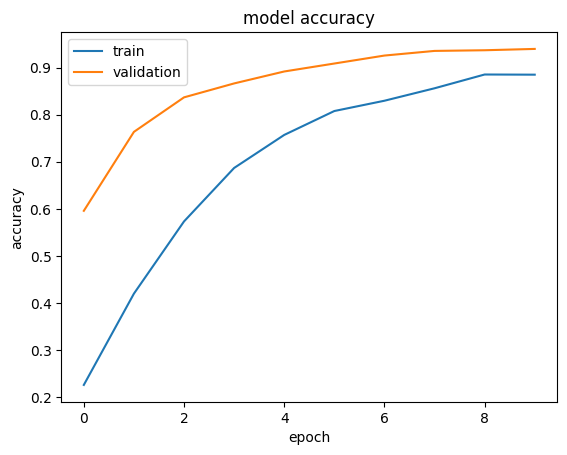

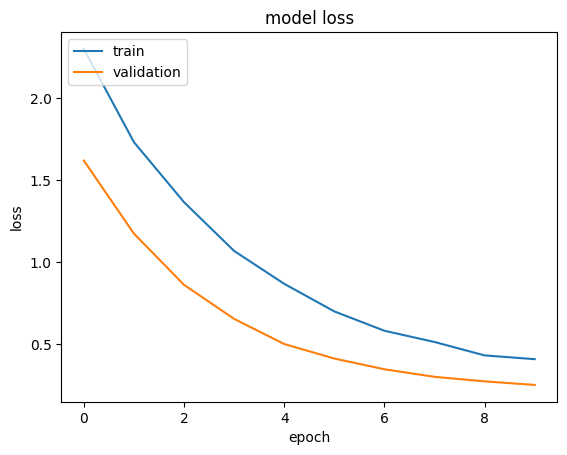

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
PROJECT_ROOT_DIR = '/content/drive/MyDrive/ass1/'
model_save_path = PROJECT_ROOT_DIR + 'www.h5'
model.save(model_save_path)
path = "/content/drive/MyDrive/ass1/"

In [15]:
loaded_model = load_model(path + "www.h5")#load model for attack

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


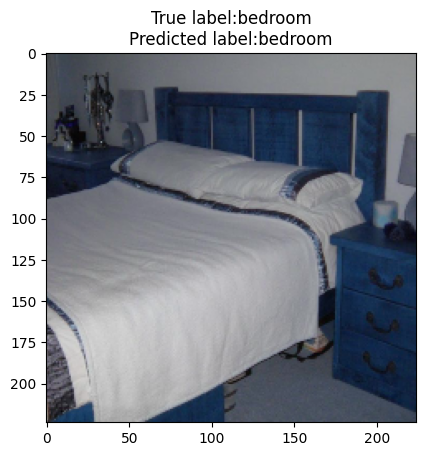

In [16]:
plt.imshow(test_images[0].astype(np.uint))
labels_dict = {0: 'airport_terminal', 1: 'amusement_park', 2: 'bedroom', 3: 'bridge', 4: 'castle', 5: 'conference_room', 6: 'golf_course', 7: 'highway', 8: 'mountain', 9: 'playground'}

true_class = labels_dict[test_labels[0]]
predicted_class = labels_dict[np.argmax(loaded_model.predict(test_images[:1]))]
plt.title('True label:' + true_class+ '\n' + 'Predicted label:' + predicted_class)
plt.show()# to look at the model work well

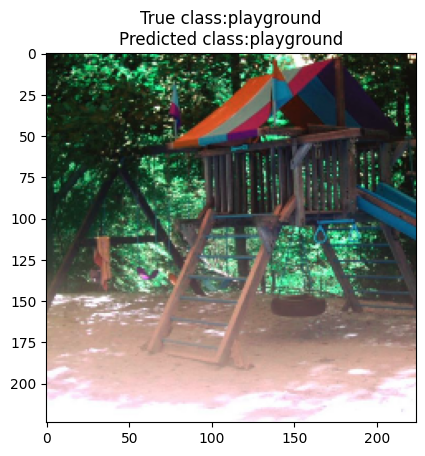

In [17]:
base_image_index = 2
sample_dog_image = test_images[base_image_index].astype(np.uint)
plt.imshow(sample_dog_image.astype(np.uint))
labels_dict = {0: 'airport_terminal', 1: 'amusement_park', 2: 'bedroom', 3: 'bridge', 4: 'castle', 5: 'conference_room', 6: 'golf_course', 7: 'highway', 8: 'mountain', 9: 'playground'}
true_class = label_names[test_labels[base_image_index]]
predicted_class = label_names[np.argmax(loaded_model.predict(test_images[base_image_index:base_image_index + 1]))]
plt.title('True class:' + true_class+ '\n' + 'Predicted class:' + predicted_class)
plt.show()


The Boundary Attack is an effective method for generating adversarial examples that can mislead machine learning models, especially deep neural networks. This attack is designed for black-box scenarios, meaning that the attacker does not have access to the model's internal architecture or gradient information.
The goal of the Boundary Attack is to iteratively approach a target input while maintaining adversarial behavior. It starts with an initial distant adversarial example that is chosen to be misclassified by the target model. Then, it gradually modifies the input by taking small steps along the boundary of the decision boundary until it reaches the target region.
To use the Boundary Attack, you typically follow these steps:
1. Select an initial input that is classified correctly by the target model but should be misclassified. This can be achieved by querying the model and finding an input that is misclassified by a small margin.
2. Define the target class you want the attack to generate an adversarial example for. This is the class you want the model to misclassify the input as.
3. Set the maximum number of iterations or the stopping criterion for the attack.
4. Initialize the current input as the initial input.
5. While the stopping criterion is not met:
    * Compute the gradient or approximate the decision boundary of the target model at the current input.
    * Move the current input towards the target region by taking a small step along the decision boundary, while ensuring the adversarial constraint is maintained.
    * If the current input is misclassified as the target class, terminate the attack and consider it successful.
    * If the current input is misclassified as a different class or remains correctly classified, update the current input and continue the iterations.
6. Once the attack terminates, you obtain the generated adversarial example that is likely to be misclassified as the target class by the target model.
It's important to note that the implementation details of the Boundary Attack can vary, and there may be additional parameters or techniques that can be used to enhance its effectiveness or efficiency.


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Adversarial image at step 0. L2 error 36276.688842594645 and class label bridge.


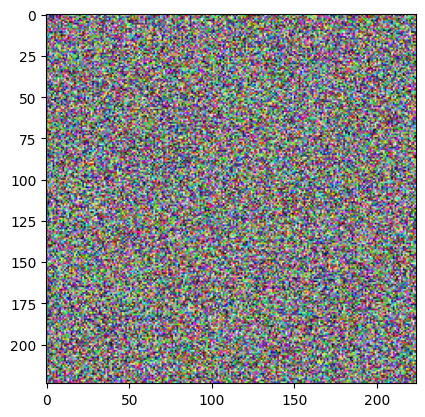

In [18]:
classifier = KerasClassifier(clip_values=(0, 255), model=loaded_model)
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.0001)
iter_step = 20
x_adv = None
target_image = test_images[0]
for i in range(20):
    x_adv = attack.generate(x=np.array([target_image[..., ::-1]]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image[..., ::-1], [-1])),
          "and class label %s." % labels_dict[np.argmax(classifier.predict(x_adv)[0])])
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    
    if hasattr(attack, 'currt_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

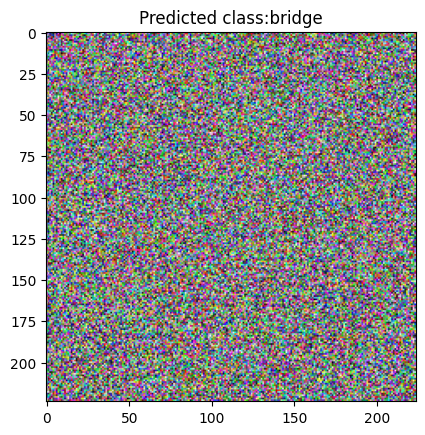

In [19]:
labels_dict = {0: 'airport_terminal', 1: 'amusement_park', 2: 'bedroom', 3: 'bridge', 4: 'castle', 5: 'conference_room', 6: 'golf_course', 7: 'highway', 8: 'mountain', 9: 'playground'}
predicted_class = labels_dict[np.argmax(classifier.predict(x_adv))]
plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
plt.title('Predicted class:' + predicted_class)
plt.show(block=False)
     

Here, we can analyze the differences between the original image and the attacked image.






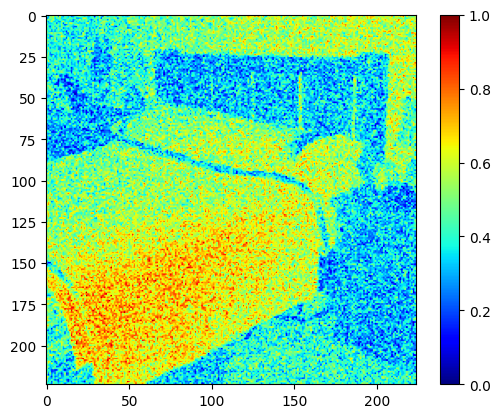

In [20]:
diff = (test_images[0] - x_adv[0][..., ::-1])
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.33, 0.33, 0.33])
def get_norm(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))
diff = rgb2gray(diff)
diff = get_norm(diff)
plt.imshow(diff, cmap=plt.get_cmap('jet'), vmin=0, vmax=1)
plt.colorbar()


The Boundary Attack is an adversarial attack method, specifically designed for black-box scenarios, aiming to generate adversarial examples that deceive machine learning models, particularly deep neural networks. It starts from an initial distant adversarial example and iteratively adjusts the input towards the desired target while maintaining its adversarial nature. Notably, this attack only requires access to the model's output, without requiring knowledge of its architecture or gradients. The existence of such attacks underscores the importance of developing robust and secure machine learning models, as well as conducting further research in the field of adversarial machine learning.






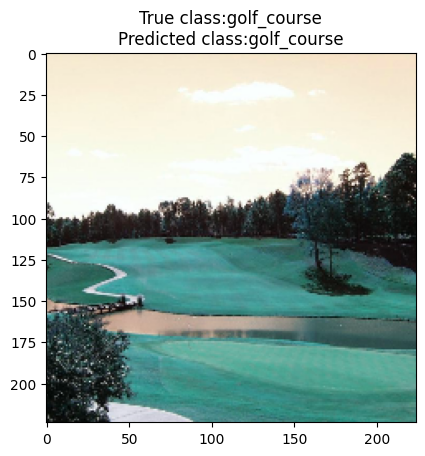

In [21]:
base_image_index = 1
plt.imshow(test_images[base_image_index].astype(np.uint))
labels_dict = {0: 'airport_terminal', 1: 'amusement_park', 2: 'bedroom', 3: 'bridge', 4: 'castle', 5: 'conference_room', 6: 'golf_course', 7: 'highway', 8: 'mountain', 9: 'playground'}
true_class = labels_dict[test_labels[base_image_index]]
predicted_class = labels_dict[np.argmax(loaded_model.predict(test_images[base_image_index:base_image_index + 1]))]
plt.title('True class:' + true_class+ '\n' + 'Predicted class:' + predicted_class)
plt.show()

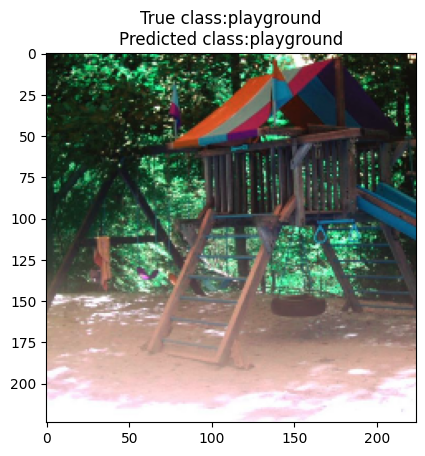

In [22]:
target_image_index = 2
plt.imshow(test_images[target_image_index].astype(np.uint))
labels_dict = {0: 'airport_terminal', 1: 'amusement_park', 2: 'bedroom', 3: 'bridge', 4: 'castle', 5: 'conference_room', 6: 'golf_course', 7: 'highway', 8: 'mountain', 9: 'playground'}
true_class = labels_dict[test_labels[target_image_index]]
predicted_class = labels_dict[np.argmax(loaded_model.predict(test_images[target_image_index: target_image_index + 1]))]
plt.title('True class:' + true_class+ '\n' + 'Predicted class:' + predicted_class)
plt.show()

save as above, here is the example of how to use the BoundaryAttack, then we can see the image changed, but the lable still same. attack successful

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Adversarial image at step 0. L2 error 54008.14446914465 and class label golf_course.


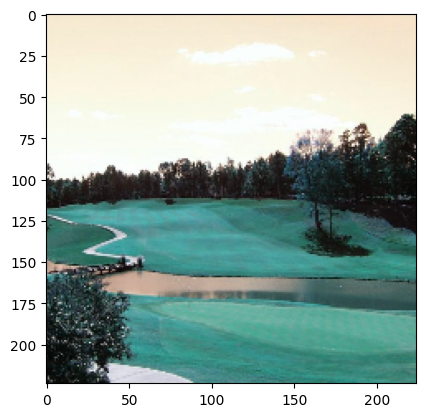

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 200. L2 error 15244.404118368982 and class label golf_course.


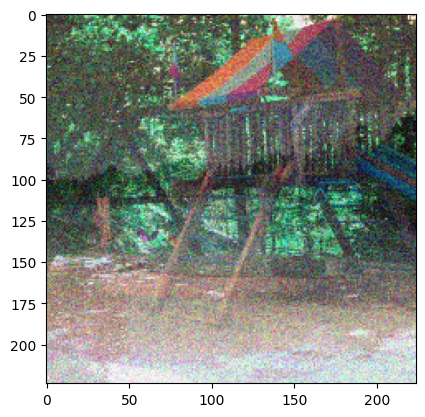

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 400. L2 error 10654.355071604676 and class label golf_course.


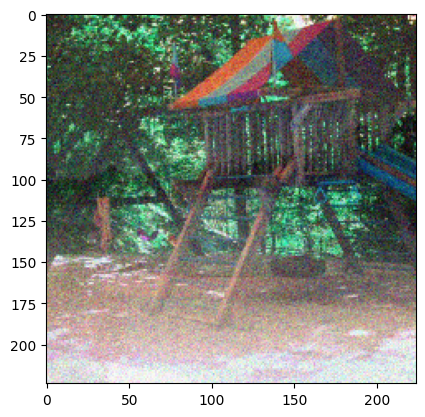

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 600. L2 error 7990.495611830438 and class label golf_course.


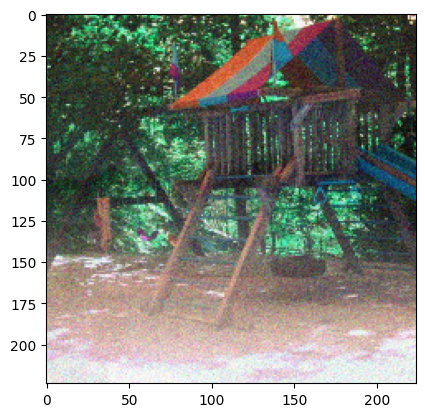

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 800. L2 error 6206.831685596874 and class label golf_course.


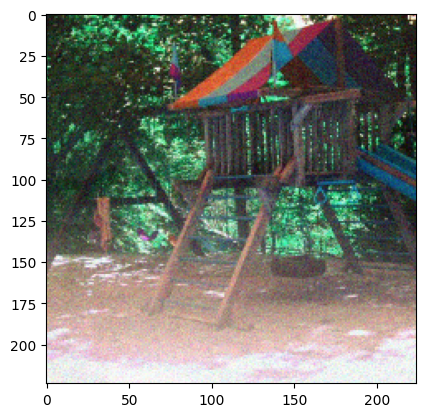

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 1000. L2 error 5094.707608513254 and class label golf_course.


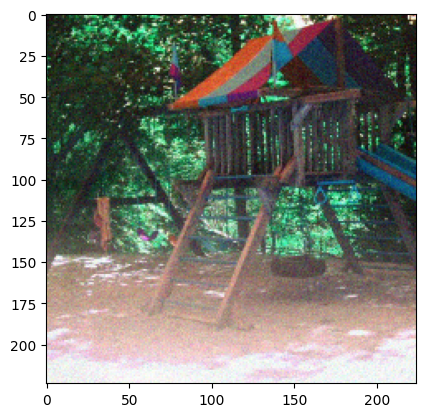

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 1200. L2 error 4287.89851522889 and class label golf_course.


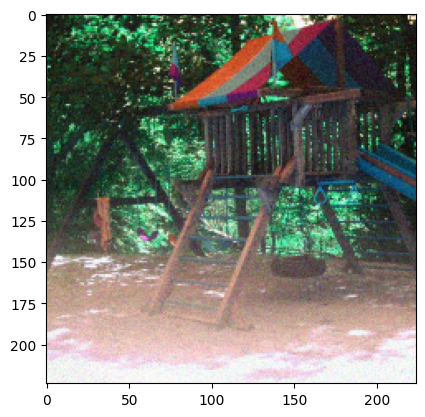

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 1400. L2 error 3665.889857696681 and class label golf_course.


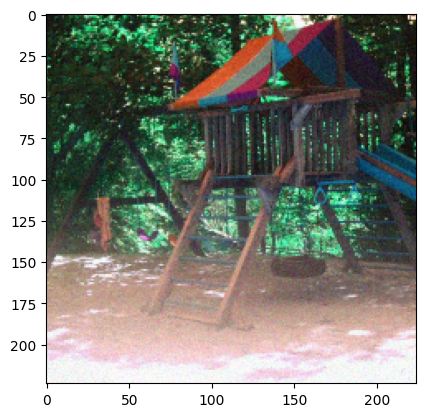

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 1600. L2 error 3258.0663275573675 and class label golf_course.


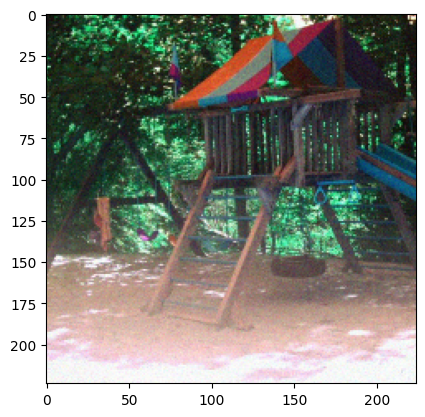

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 1800. L2 error 2909.6434638576084 and class label golf_course.


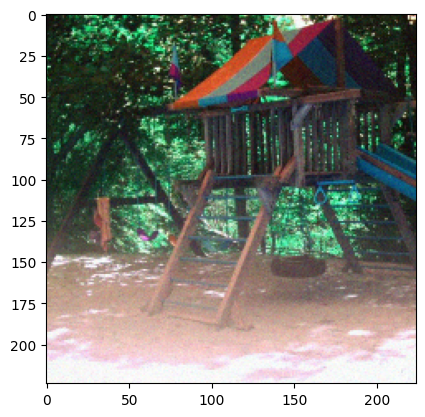

In [23]:
classifier = KerasClassifier(clip_values=(0, 255), model=loaded_model)
iter_step = 200
x_adv = np.array([test_images[1][..., ::-1]])
target_image = test_images[2]

attack = BoundaryAttack(estimator=classifier, targeted=True, max_iter=0, delta=0.01, epsilon=0.01)
labels_dict = {0: 'airport_terminal', 1: 'amusement_park', 2: 'bedroom', 3: 'bridge', 4: 'castle', 5: 'conference_room', 6: 'golf_course', 7: 'highway', 8: 'mountain', 9: 'playground'}

for i in range(10):
    x_adv = attack.generate(x=np.array([target_image[..., ::-1]]), y=to_categorical([test_labels[1]], 10), x_adv_init=x_adv)

    #clear_output()    
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image[..., ::-1], [-1])),
          "and class label %s." % labels_dict[np.argmax(classifier.predict(x_adv)[0])])
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

Hands-on example: fooling a deep learning-based image classifier

Adversarial image at step 0. L2 error 25391.766839089843 and class label amusement_park.


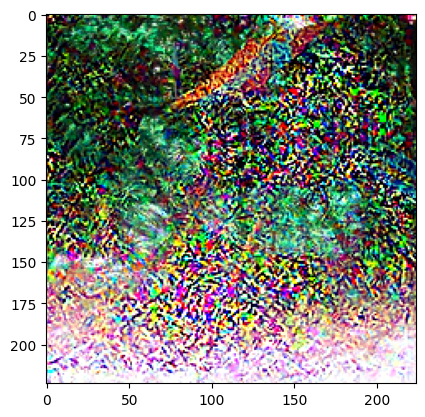

In [29]:
from art.attacks.evasion import FastGradientMethod,ProjectedGradientDescent,DeepFool

classifier = KerasClassifier(clip_values=(0, 255), model=loaded_model)
iter_step = 200
x_adv = np.array([test_images[1][..., ::-1]])
target_image = test_images[2]

attack = DeepFool(classifier=classifier, max_iter=100, verbose = False, epsilon=0.01)
labels_dict = {0: 'airport_terminal', 1: 'amusement_park', 2: 'bedroom', 3: 'bridge', 4: 'castle', 5: 'conference_room', 6: 'golf_course', 7: 'highway', 8: 'mountain', 9: 'playground'}

for i in range(10):
    x_adv = attack.generate(x=np.array([target_image[..., ::-1]]), y=to_categorical([test_labels[1]], 10), x_adv_init=x_adv)

    #clear_output()    
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image[..., ::-1], [-1])),
          "and class label %s." % labels_dict[np.argmax(classifier.predict(x_adv)[0])])
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

crafted inputs that are designed to deceive a deep learning model into misclassifying them.
Here's a step-by-step guide on how to create an adversarial example using the Fast Gradient Sign Method (FGSM), one of the commonly used methods for generating adversarial examples:
1. Set up the environment:
    * Install the required libraries, such as TensorFlow or PyTorch, depending on your preference.
    * Download a pre-trained deep learning model that you want to attack. You can use popular pre-trained models like VGG16 or ResNet50.
2. Load the pre-trained model:
    * Load the pre-trained model into your programming environment.
    * Make sure to set the model to evaluation mode to disable any training-specific behaviors.
3. Choose the target image:
    * Select an image that you want to classify.
    * Ensure that the image is correctly preprocessed to match the input requirements of the model.
4. Compute the adversarial perturbation:
    * Calculate the gradient of the loss function with respect to the input image pixels.
    * Perturb the image by adding a small step in the direction that maximizes the loss function.
    * The perturbation magnitude is determined by a hyperparameter called epsilon, which controls the strength of the attack.
5. Generate the adversarial example:
    * Add the adversarial perturbation to the original image to create the adversarial example.
    * Make sure to clip the pixel values to the valid range (e.g., 0-255 for RGB images).
6. Test the adversarial example:
    * Feed the adversarial example into the pre-trained model and observe the output.
    * Verify that the model misclassifies the adversarial example by checking the predicted class label.
By following these steps, you should be able to generate an adversarial example that can fool a deep learning-based image classifier. However, it's important to note that adversarial examples are typically specific to the model they were generated for, and they may not generalize well to other models or settings. Additionally, always make sure to use these techniques responsibly and ethically.
